Import library

In [3]:
import pandas as pd
import numpy as np
import os
import shutil
import random
from tqdm import tqdm
from pathlib import Path
import cv2 as cv
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import layers, optimizers, losses, metrics, callbacks, initializers
from tensorflow.keras import Sequential, Model, Input
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3, MobileNetV2, VGG16
from sklearn.model_selection import train_test_split
import tensorflow_addons as tfa

from keras.utils.vis_utils import plot_model

In [2]:
pip install -U tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 5.3 MB/s 


In [4]:
train_data_path = "/content/drive/MyDrive/paddy-disease-classification/train_images"

In [5]:
validation_data_path = "/content/drive/MyDrive/paddy-disease-classification/test_images"

In [6]:
import glob
import os
from tqdm import tqdm
from PIL import  Image, ImageFile
from joblib  import Parallel, delayed
import shutil
ImageFile.LOAD_TRUNCATED_IMAGES = True

Load Image and Understand Some Properties

In [7]:
def image_properties(path):
    for img in random.sample(os.listdir(path),1):
        print('Image name =',img)
        image = cv.imread(os.path.join(path, img),cv.IMREAD_COLOR)
        break
        
    return image

Image name = 100810.jpg
The dimensions are 640 pixels height and 480 pixels width
The maximum pixel value is 255.00
The minimum pixel value is 0.00
The mean value of the pixels is 105.79
The standard deviation is 70.93


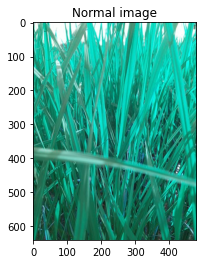

In [8]:
path = '/content/drive/MyDrive/paddy-disease-classification/train_images/normal'
image = image_properties(path)
plt.imshow(image)
plt.title('Normal image')
print(f"The dimensions are {image.shape[0]} pixels height and {image.shape[1]} pixels width")
print(f"The maximum pixel value is {image.max():.2f}")
print(f"The minimum pixel value is {image.min():.2f}")
print(f"The mean value of the pixels is {image.mean():.2f}")
print(f"The standard deviation is {image.std():.2f}")

Loading a dataset

In [9]:
batch_size = 64
img_height = 256
img_width =  256

data_dir = '/content/drive/MyDrive/paddy-disease-classification/train_images'

Data Normalization

In [10]:
img_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                            rescale=1.0/255.0,
                            validation_split=0.3,
                            rotation_range=5,
                            shear_range=0.3,
                            zoom_range=0.3,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            horizontal_flip=True,
                            vertical_flip=True
                )

Training Dataset

In [11]:
train_gen = img_datagen.flow_from_directory(
                            data_dir,
                            subset="training",
                            seed=42,
                            target_size=(img_height, img_width),
                            batch_size=batch_size,
                            class_mode="categorical",
                            color_mode='rgb'
            )

Found 7288 images belonging to 10 classes.


Testing Dataset

In [12]:
valid_gen = img_datagen.flow_from_directory(
                            data_dir,
                            subset="validation",
                            seed=42,
                            target_size=(img_height, img_width),
                            batch_size=batch_size,
                            class_mode="categorical"
            )

Found 3119 images belonging to 10 classes.


Class Label

In [13]:
print('Total No Of Classes in the datasetL:',len(train_gen.class_indices))
print('Class Names:',train_gen.class_indices)

Total No Of Classes in the datasetL: 10
Class Names: {'bacterial_leaf_blight': 0, 'bacterial_leaf_streak': 1, 'bacterial_panicle_blight': 2, 'blast': 3, 'brown_spot': 4, 'dead_heart': 5, 'downy_mildew': 6, 'hispa': 7, 'normal': 8, 'tungro': 9}


Displaying random image from dataset

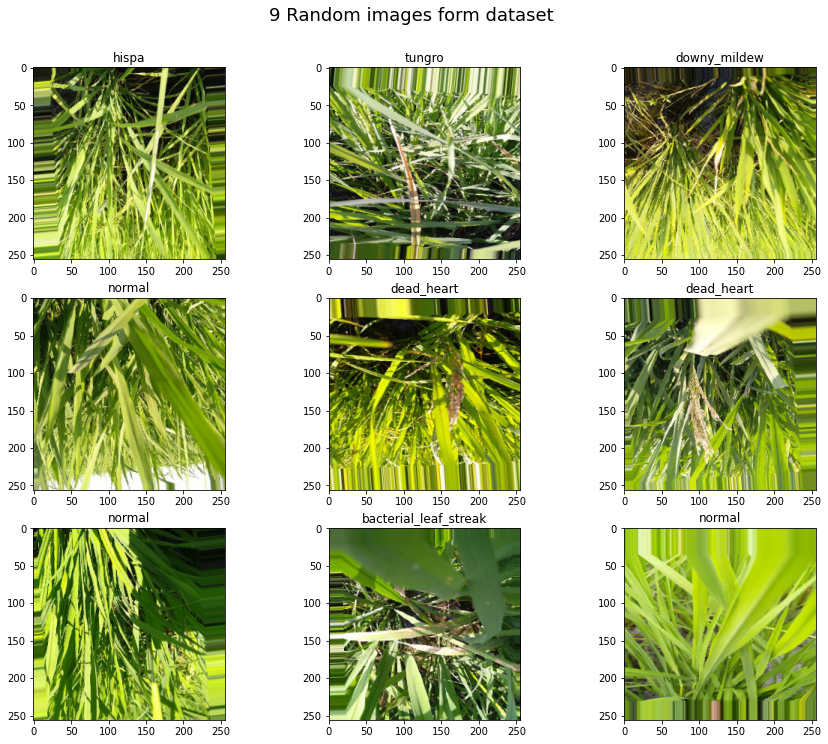

In [14]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))
plt.subplots_adjust(hspace=0.2)
fig.suptitle("9 Random images form dataset", fontsize=18, y=0.95)

for i in range(1,10):
    plt.subplot(3,3,i)
    img, label = train_gen.next()
    plt.title(list(train_gen.class_indices.keys())[np.argmax(label)])
    plt.imshow(img[0])

CNN Model

In [15]:
num_classes = 10
input_shape = (batch_size,256,256,3)

In [16]:
model = None
model = tf.keras.Sequential([
                             
        tf.keras.layers.Conv2D(16, (3,3), activation='relu' ),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
])

model.build(input_shape=input_shape)

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (64, 254, 254, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (64, 127, 127, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (64, 125, 125, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (64, 62, 62, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (64, 60, 60, 64)          18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (64, 30, 30, 64)         0

Call back

In [18]:
class TerminateNaN(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    loss = logs.get('loss')
    if loss is not None:
      if np.isnan(loss) or np.isinf(loss):
        print('Invalid loss and terminated at loss {}'.format(epoch))
        self.model.stop_training = True

terminate_nan = TerminateNaN()

In [19]:
# save model after every epoch if the validation accuracy improves from previous epoch
filepath = '/content/drive/MyDrive/paddy_models/model_vgg_new.hdf5'

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = filepath,
    monitor="val_categorical_accuracy",
    verbose=1,
    save_best_only=True,
    mode = 'auto'
)

In [20]:
# learning rate scheduler
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_categorical_accuracy",
    factor=0.1,
    patience=1,
    verbose=1,
    mode="auto",
    min_delta=0.001,
    cooldown=3,
    min_lr=0
)

In [21]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy(name="categorical_accuracy", dtype=None)]
)

In [22]:
history = model.fit(
    train_gen,
    batch_size = batch_size,
    validation_data = valid_gen,
    epochs=20,
    verbose=1,
    callbacks=[terminate_nan, checkpoint, reduce_lr]
)

Epoch 1/20
114/114 [==============================] - ETA: 0s - loss: 2.0533 - categorical_accuracy: 0.2667 
Epoch 1: val_categorical_accuracy improved from -inf to 0.33184, saving model to /content/drive/MyDrive/paddy_models/model_vgg_new.hdf5
114/114 [==============================] - 2640s 23s/step - loss: 2.0533 - categorical_accuracy: 0.2667 - val_loss: 1.9125 - val_categorical_accuracy: 0.3318 - lr: 3.0000e-04
Epoch 2/20
114/114 [==============================] - ETA: 0s - loss: 1.8409 - categorical_accuracy: 0.3616
Epoch 2: val_categorical_accuracy improved from 0.33184 to 0.37095, saving model to /content/drive/MyDrive/paddy_models/model_vgg_new.hdf5
114/114 [==============================] - 793s 7s/step - loss: 1.8409 - categorical_accuracy: 0.3616 - val_loss: 1.8242 - val_categorical_accuracy: 0.3710 - lr: 3.0000e-04
Epoch 3/20
114/114 [==============================] - ETA: 0s - loss: 1.7244 - categorical_accuracy: 0.4027
Epoch 3: val_categorical_accuracy improved from 0.37

Training Vs Validation Loss

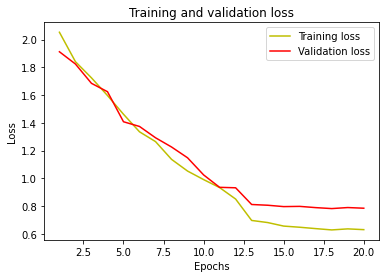

In [23]:
history = history
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Training Vs Validation Accuracy

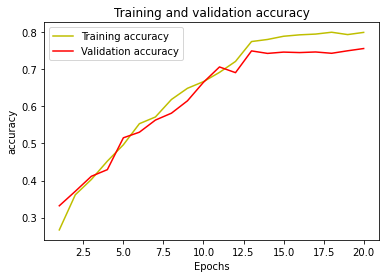

In [24]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [25]:
loss, accuracy = model.evaluate(valid_gen)

49/49 [==============================] - 125s 3s/step - loss: 0.7843 - categorical_accuracy: 0.7547


In [27]:
print('Validation Accuracy', accuracy)

Validation Accuracy 0.7547290921211243
